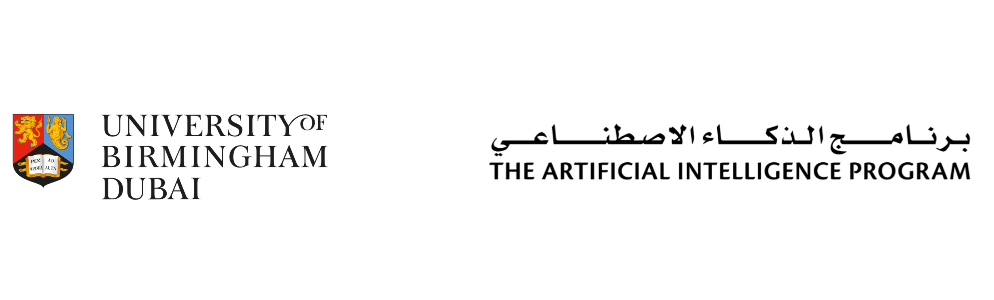

# Stable Diffusion: Deep Dive

Stable Diffusion is a powerful text-to-image model. There are various websites and tools to make using it as easy as possible. It is also [integrated into the Huggingface diffusers library](https://huggingface.co/blog/stable_diffusion) where generating images can be as simple as:
```python
from diffusers import StableDiffusionPipeline
pipe = StableDiffusionPipeline.from_pretrained("CompVis/stable-diffusion-v1-4", variant="fp16", torch_dtype=torch.float16, use_auth_token=True).to("cuda")
image = pipe("An astronaught scuba diving").images[0]

```

In this notebook we're going to dig into the code behind these easy-to-use interfaces, to see what is going on under the hood. We'll begin by re-creating the functionality above as a scary chunk of code, and then one by one we'll inspect the different components and figure out what they do. By the end of this notebook that same sampling loop should feel like something you can tweak and modify as you like.

## Setup & Imports

You'll need to log into huggingface and accept the terms of the licence for this model - see the [model card](https://huggingface.co/CompVis/stable-diffusion-v1-4) for details. And when you first run this notebook you need to uncomment the following two cells to install the requirements and log in to huggingface with an access token.

In [ ]:
!pip uninstall -y diffusers transformers huggingface_hub accelerate ftfy peft
!pip install --no-cache-dir diffusers==0.27.2 transformers==4.40.1 huggingface_hub==0.23.0 accelerate==0.32.0 ftfy peft==0.11.0

Found existing installation: diffusers 0.34.0
Uninstalling diffusers-0.34.0:
  Successfully uninstalled diffusers-0.34.0
Found existing installation: transformers 4.53.3
Uninstalling transformers-4.53.3:
  Successfully uninstalled transformers-4.53.3
Found existing installation: huggingface-hub 0.33.5
Uninstalling huggingface-hub-0.33.5:
  Successfully uninstalled huggingface-hub-0.33.5
Found existing installation: accelerate 1.9.0
Uninstalling accelerate-1.9.0:
  Successfully uninstalled accelerate-1.9.0
Found existing installation: peft 0.16.0
Uninstalling peft-0.16.0:
  Successfully uninstalled peft-0.16.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.0/138.0 kB 8.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 61.0/61.0 kB 209.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 76.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.0/9.0 MB 95.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 266.7 MB/

In [ ]:
from base64 import b64encode

import numpy
import torch
from diffusers import AutoencoderKL, LMSDiscreteScheduler, UNet2DConditionModel
from huggingface_hub import notebook_login

# For video display:
from IPython.display import HTML
from matplotlib import pyplot as plt
from pathlib import Path
from PIL import Image
from torch import autocast
from torchvision import transforms as tfms
from tqdm.auto import tqdm
from transformers import CLIPTextModel, CLIPTokenizer, logging
import os

torch.manual_seed(1)
if not (Path.home()/'.cache/huggingface'/'token').exists(): notebook_login()

# Supress some unnecessary warnings when loading the CLIPTextModel
logging.set_verbosity_error()

# Set device
torch_device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
if "mps" == torch_device: os.environ['PYTORCH_ENABLE_MPS_FALLBACK'] = "1"

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


0it [00:00, ?it/s]

## Loading the models

This code (and that in the next section) comes from the [Huggingface example notebook](https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/stable_diffusion.ipynb).

This will download and set up the relevant models and components we'll be using. Let's just run this for now and move on to the next section to check that it all works before diving deeper.

In this notebook we aren't doing any memory-saving tricks - if you find yourself running out of GPU RAM, look at the pipeline code for inspiration with things like attention slicing, switching to half precision (fp16), keeping the VAE on the CPU and other modifications.

In [ ]:
# Load the autoencoder model which will be used to decode the latents into image space.
vae = AutoencoderKL.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="vae")

# Load the tokenizer and text encoder to tokenize and encode the text.
tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14")

# The UNet model for generating the latents.
unet = UNet2DConditionModel.from_pretrained("CompVis/stable-diffusion-v1-4", subfolder="unet")

# The noise scheduler
scheduler = LMSDiscreteScheduler(beta_start=0.00085, beta_end=0.012, beta_schedule="scaled_linear", num_train_timesteps=1000)

# To the GPU we go!
vae = vae.to(torch_device)
text_encoder = text_encoder.to(torch_device)
unet = unet.to(torch_device);

/usr/local/lib/python3.11/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/551 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/905 [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/389 [00:00<?, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/1.71G [00:00<?, ?B/s]

config.json:   0%|          | 0.00/743 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.44G [00:00<?, ?B/s]

## Full Diffusion Loop

What we want to do in this notebook is dig a little deeper into how diffusion works through its various components, so we'll start by checking that the example code runs. Again, this is adapted from the [HF notebook](https://colab.research.google.com/github/huggingface/notebooks/blob/main/diffusers/stable_diffusion.ipynb) and looks very similar to what you'll find if you inspect [the `__call__()` method of the stable diffusion pipeline](https://github.com/huggingface/diffusers/blob/main/src/diffusers/pipelines/stable_diffusion/pipeline_stable_diffusion.py#L200).  

/tmp/ipython-input-4-174285752.py:48: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),


  0%|          | 0/30 [00:00<?, ?it/s]

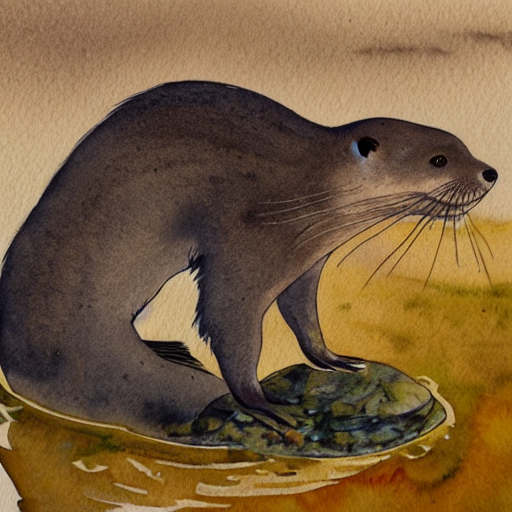

In [ ]:
# ------------------------------------ Parameters ------------------------------------
prompt = ["A watercolor painting of an otter"]
height = 512                        # Output image height
width = 512                         # Output image width
num_inference_steps = 30            # Number of denoising steps during generation
guidance_scale = 7.5                # Controls how closely image follows the prompt
generator = torch.manual_seed(32)   # Seed for reproducibility
batch_size = 1                      # Number of images to generate

# ------------------------------------ Tokenize text prompt ------------------------------------
# Encode the text prompt into token IDs
text_input = tokenizer(
    prompt,
    padding="max_length",
    max_length=tokenizer.model_max_length,
    truncation=True,
    return_tensors="pt"
)

# Get text embeddings from the text encoder
with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]

# Prepare unconditional embeddings (used for classifier-free guidance)
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer(
    [""] * batch_size,
    padding="max_length",
    max_length=max_length,
    return_tensors="pt"
)
with torch.no_grad():
    uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]

# Concatenate conditional and unconditional embeddings
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

# ------------------------------------ Prepare the scheduler ------------------------------------
def set_timesteps(scheduler, num_inference_steps):
    scheduler.set_timesteps(num_inference_steps)
    scheduler.timesteps = scheduler.timesteps.to(torch.float32)  # Ensures compatibility on Apple MPS

set_timesteps(scheduler, num_inference_steps)

# ------------------------------------ Initialize latent noise ------------------------------------
# Create random latent noise tensor of appropriate shape
latents = torch.randn(
    (batch_size, unet.in_channels, height // 8, width // 8),
    generator=generator,
).to(torch_device)

# Scale the latents using the scheduler's initial sigma
latents = latents * scheduler.init_noise_sigma

# ------------------------------------ Denoising loop ------------------------------------
# Uses autocast for mixed precision if on CUDA
with autocast("cuda"):
    for i, t in tqdm(enumerate(scheduler.timesteps), total=len(scheduler.timesteps)):
        # Duplicate latents for classifier-free guidance (unconditional + conditional)
        latent_model_input = torch.cat([latents] * 2)

        # Scale inputs to match model preconditioning expectations
        latent_model_input = scheduler.scale_model_input(latent_model_input, t)

        # Predict the noise residual using the UNet
        with torch.no_grad():
            noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

        # Apply classifier-free guidance
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

        # Update latents using the scheduler step
        latents = scheduler.step(noise_pred, t, latents).prev_sample

# ------------------------------------ Decode latents into image space ------------------------------------
# Rescale latents back to original range expected by VAE
latents = 1 / 0.18215 * latents

# Decode latents to image using VAE
with torch.no_grad():
    image = vae.decode(latents).sample

# --------------------------------------- Post-processing and visualization ---------------------------------------
# Normalize image pixels to [0, 1]
image = (image / 2 + 0.5).clamp(0, 1)

# Convert to NumPy array and format for PIL
image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
images = (image * 255).round().astype("uint8")

# Convert to PIL images and display the first one
pil_images = [Image.fromarray(image) for image in images]
pil_images[0]

## Component 1: The Autoencoder

- **What is an autoencoder?**
  - An **autoencoder** is a type of neural network designed to compress and then reconstruct data.

  - It has two main parts:
    1. **Encoder**: Squashes input into a small, dense latent representation.
    2. **Decoder**: Reconstructs the original input from that latent representation.

  - They're useful because they learn data compression that preserves the most semantically useful information of an image but reduces the image's "size".

- **What is their use in Stable Diffusion?**
  - In the context of *Stable Diffusion*, we use a special kind of autoencoder called a **VAE (Variational Autoencoder)**
  1. **VAE Encoder**: Compresses high-res images (e.g. 512×512) into a smaller latent code.
  2. **Latent Diffusion Model (LDM)**: Runs the diffusion process in this smaller space.
  3. **VAE Decoder**: Converts the final latent back into an image.

- **Why Not Run the Diffusion Process on Pixels Directly?**
  - Well, working on full-res images:
  - Is computationally expensive.
  - Is harder for the model to learn useful structure.
  - Slows everything down.

  - By using a variational autoencoder to project our images into the latent space where we then rune the diffusion process:
    - The model works on compressed info (from 3x512x512 images to 4x64x64).
    - It still keeps important visual features.
    - Training is much more efficient!

In [ ]:
# These are the functions we will use to encode and decode an image with an already-trained VAE.

def pil_to_latent(input_im):
    # Convert a PIL image to a latent vector using the VAE encoder.
    # Output is a latent of shape (1, 4, 64, 64)

    with torch.no_grad():
        # Convert image to tensor (range [0, 1]), then scale to [-1, 1] as VAE expects
        tensor = tfms.ToTensor()(input_im).unsqueeze(0).to(torch_device) * 2 - 1

        # Pass through the VAE encoder
        latent = vae.encode(tensor)

    # Sample from the latent distribution and scale by 0.18215
    # This scaling ensures unit variance in latent space for diffusion
    return 0.18215 * latent.latent_dist.sample()

def latents_to_pil(latents):
    # Convert a batch of latent vectors back to PIL images using the VAE decoder

    # Reverse the scaling: bring latent back to original VAE range
    latents = (1 / 0.18215) * latents

    with torch.no_grad():
        # Decode the latents to image tensors (range [-1, 1])
        image = vae.decode(latents).sample

    # Convert image range from [-1, 1] → [0, 1]
    image = (image / 2 + 0.5).clamp(0, 1)

    # Rearrange dimensions: (B, C, H, W) → (B, H, W, C), move to CPU
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()

    # Convert to uint8 format for PIL, scale to [0, 255]
    images = (image * 255).round().astype("uint8")

    # Convert each image array to PIL format
    pil_images = [Image.fromarray(image) for image in images]

    return pil_images

### Using the Variational Autoencoder

Let's explore the properties of this variational autoencoder with a random image from our reliable Parrot image from the internet.

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 58602  100 58602    0     0   593k      0 --:--:-- --:--:-- --:--:--  596k


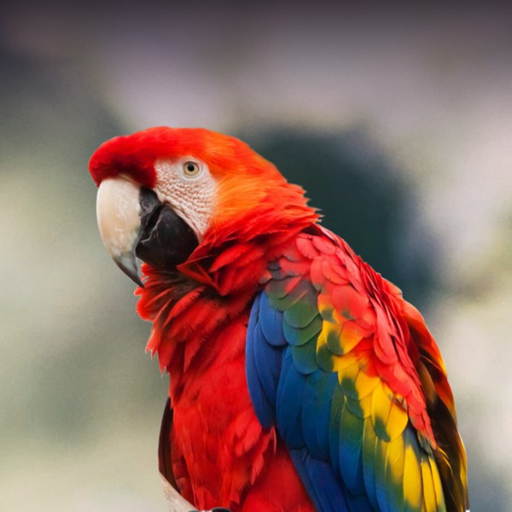

In [ ]:
# Download a demo Image
!curl --output macaw.jpg 'https://lafeber.com/pet-birds/wp-content/uploads/2018/06/Scarlet-Macaw-2.jpg'

# Load the image with PIL
input_image = Image.open('macaw.jpg').resize((512, 512))
input_image

Let's encode this image into the latent space!

The shape of the encoded image is torch.Size([1, 4, 64, 64])
Let's visualize the four channels (each is of shape 64x64) of this latent representation:


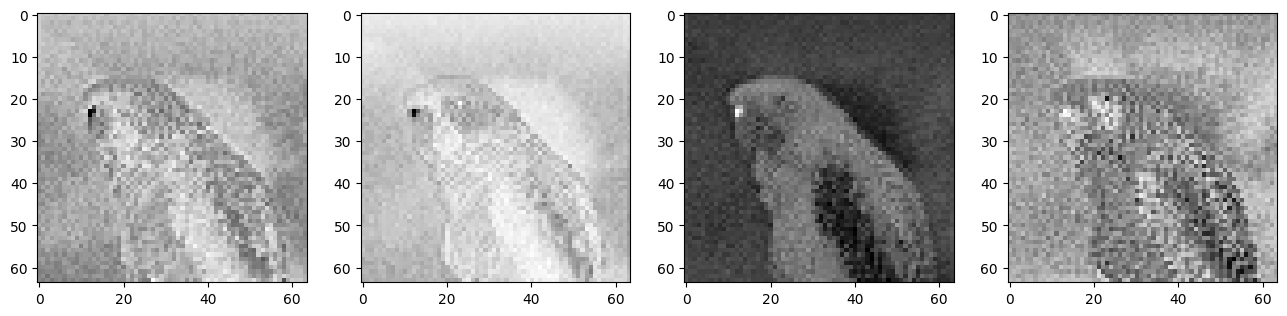

In [ ]:
# Encode to the latent space
encoded = pil_to_latent(input_image)
print(f"The shape of the encoded image is {encoded.shape}")
print("Let's visualize the four channels (each is of shape 64x64) of this latent representation:")

# Let's visualize the four channels of this latent representation:
fig, axs = plt.subplots(1, 4, figsize=(16, 4))
for c in range(4):
    axs[c].imshow(encoded[0][c].cpu(), cmap='Greys')

Let's try and use the VAE decoder (the other component of the VAE encoder-decoder pair) to see how it recovers the original image using just  this latent representation.

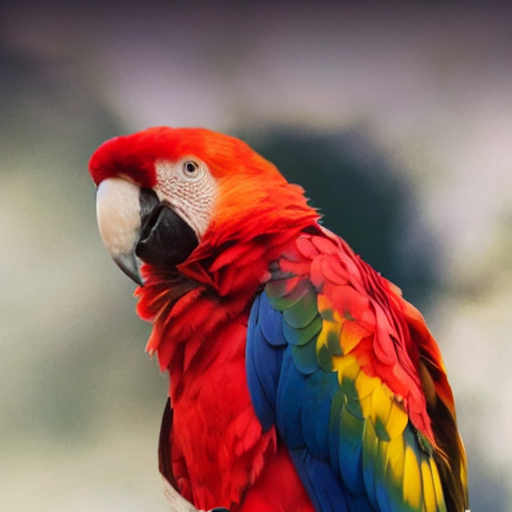

In [ ]:
# Decode this latent representation back into an image
decoded = latents_to_pil(encoded)[0]
decoded

- You'll see some small differences if you squint! This is pretty impressive - that 4x64x64 latent seems to hold a lot more information that a 64px image...

- So:
  - Latent diffusion does the diffusion process in this 'latent space', using the compressed representations from our AE rather than raw images.
  - These representations are information rich, and can be small enough to handle manageably on consumer hardware.
  - Once we've generated a new 'image' as a latent representation from denoising, the autoencoder's decoder can take those final latent outputs and turn them into actual pixels.

## Component 2: Text Encoder

**What is the text encoder component used in Stable Diffusion?**
- In Stable Diffusion, the text encoder is a model that takes in your prompt (text string) and converts it into a dense numerical representation — called embeddings.
- These embeddings capture the semantic meaning of your prompt: e.g., colors, objects, styles, relationships, and so on.

**What model is used for the text encoder?**
- Stable Diffusion uses the CLIP text encoder (from OpenAI’s CLIP model).
- It was pretrained on hundreds of millions of image–text pairs from the internet

**How is the input text converted into a representation that can be used in the reverse diffusion process?**
Here is a step-by-step process of how the text is processed:
1. **Tokenization**:
  - Convert a string of text into a sequence of tokens that a model can understand.
  - "a red sports car" -> \["a", "red", "sports", "car"\] -> \[49406, 320, 1125, 733, 539, 49407] (tensor of token IDs from the CLIP vocabulary including \[START\] and \[END\] tokens)
2. **Token Embeddings**:
  - Each token ID is mapped to a learned vector (embedding!!)
  - The embedding matrix has shape \[vocab_size, emebdding_dim\]
  - Each token is now converted into 768 numbers!
3. **Positional Embeddings**:
  - Transformers have no built-in sense of order, so we add positional embeddings to encode the position of each token in the sequence.
  - These are also learned vectors.
4. **Combining Token and Positional Embeddings**:
  - The token and positional embeddings are added element-wise.
  - This results in a final embedded sequence that contains both the meaning of the word and its position in the sentence.
5. **Feeding into the Transformer Encoder**:
  - The combined embeddings are passed into a pre-trained transformer encoder.
  - This computes contextual embeddings: each token representation now reflects the meaning of the entire sentence around it.
  - The \[1, 77, 768\] tensor is the final text embedding used to represent the text.
6. **How the U-Net uses these encoded representations**:
  - This encoded representation is passed into the U-Net as conditioning.
  - The U-Net internally uses cross-attention to attend to relevant words when denoising the image.


Let's play with this text embedding pipeline!

In [ ]:
def build_causal_attention_mask(bsz, seq_len, dtype, device):
    # lazily create causal attention mask, with full attention between the vision tokens
    # pytorch uses additive attention mask; fill with -inf
    mask = torch.empty(bsz, seq_len, seq_len, dtype=dtype)
    mask.fill_(torch.tensor(torch.finfo(dtype).min))
    mask.triu_(1)  # zero out the lower diagonal
    mask = mask.unsqueeze(1)  # expand mask
    return mask.to(device)

def get_output_embeds(input_embeddings):
    """
    Takes manually constructed input embeddings (token + position) and runs them
    through the CLIP text transformer, including correct causal attention mask.
    """
    bsz, seq_len = input_embeddings.shape[:2]

    # 1. Proper causal mask shape for CLIPTextTransformer: (bsz, 1, seq_len, seq_len)
    causal_attention_mask = build_causal_attention_mask(
        bsz, seq_len,
        dtype=input_embeddings.dtype,
        device=input_embeddings.device
    )

    # 2. Pass through transformer encoder
    encoder_outputs = text_encoder.text_model.encoder(
        inputs_embeds=input_embeddings,
        attention_mask=None,
        causal_attention_mask=causal_attention_mask,
        output_attentions=None,
        output_hidden_states=True,
        return_dict=None,
    )

    # 3. Final hidden state (last layer output)
    output = encoder_outputs[0]

    # 4. Final LayerNorm
    output = text_encoder.text_model.final_layer_norm(output)

    return output

prompt = 'A picture of a puppy'

# Step 1: Tokenize
text_input = tokenizer(prompt, padding="max_length", max_length=77, truncation=True, return_tensors="pt")
input_ids = text_input.input_ids.to(torch_device)

# Step 2: Get token embeddings
token_emb_layer = text_encoder.text_model.embeddings.token_embedding
token_embeddings = token_emb_layer(input_ids)

# Step 3: Get position embeddings
pos_emb_layer = text_encoder.text_model.embeddings.position_embedding
position_ids = torch.arange(77, device=torch_device).unsqueeze(0)
position_embeddings = pos_emb_layer(position_ids)

# Step 4: Combine (add) the token and position embeddings
input_embeddings = token_embeddings + position_embeddings

# Step 5: Feed the combined embeddings into the Transformer to get the final output embeddings
modified_output_embeddings = get_output_embeds(input_embeddings)

print(f"Here is the shape of the final text representations: {modified_output_embeddings.shape}")
print(f"Here is the final text representation:{modified_output_embeddings}")

Here is the shape of the final text representations: torch.Size([1, 77, 768])
Here is the final text representation:tensor([[[-0.3884,  0.0229, -0.0522,  ..., -0.4899, -0.3066,  0.0675],
         [ 0.0290, -1.3258,  0.3085,  ..., -0.5257,  0.9768,  0.6652],
         [ 0.6942,  0.3538,  1.0991,  ..., -1.5716, -1.2643, -0.0121],
         ...,
         [-0.0221, -0.0053, -0.0089,  ..., -0.7303, -1.3830, -0.3011],
         [-0.0062, -0.0246,  0.0065,  ..., -0.7326, -1.3745, -0.2953],
         [-0.0536,  0.0269,  0.0444,  ..., -0.7159, -1.3634, -0.3075]]],
       device='cuda:0', grad_fn=<NativeLayerNormBackward0>)


  0%|          | 0/30 [00:00<?, ?it/s]

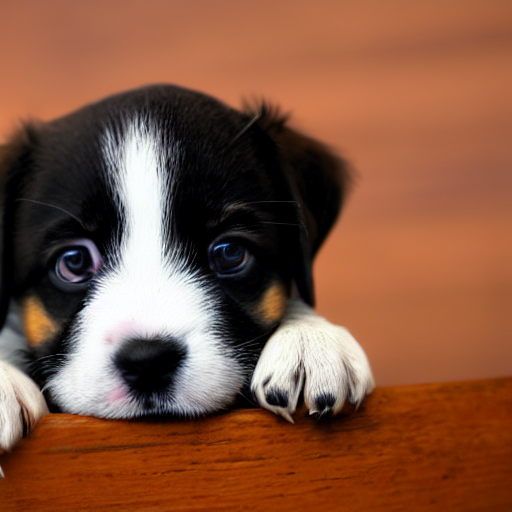

In [ ]:
#Generating an image with these modified embeddings

def generate_with_embs(text_embeddings):
    height = 512                        # default height of Stable Diffusion
    width = 512                         # default width of Stable Diffusion
    num_inference_steps = 30            # Number of denoising steps
    guidance_scale = 7.5                # Scale for classifier-free guidance
    generator = torch.manual_seed(32)   # Seed generator to create the inital latent noise
    batch_size = 1

    max_length = text_input.input_ids.shape[-1]
    uncond_input = tokenizer(
      [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
    )
    with torch.no_grad():
        uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]
    text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

    # Prep Scheduler
    set_timesteps(scheduler, num_inference_steps)

    # Prep latents
    latents = torch.randn(
    (batch_size, unet.config.in_channels, height // 8, width // 8),
    generator=generator,
    )
    latents = latents.to(torch_device)
    latents = latents * scheduler.init_noise_sigma

    # Loop
    for i, t in tqdm(enumerate(scheduler.timesteps), total=len(scheduler.timesteps)):
        # expand the latents if we are doing classifier-free guidance to avoid doing two forward passes.
        latent_model_input = torch.cat([latents] * 2)
        sigma = scheduler.sigmas[i]
        latent_model_input = scheduler.scale_model_input(latent_model_input, t)

        # predict the noise residual
        with torch.no_grad():
            noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings)["sample"]

        # perform guidance
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

        # compute the previous noisy sample x_t -> x_t-1
        latents = scheduler.step(noise_pred, t, latents).prev_sample

    return latents_to_pil(latents)[0]

generate_with_embs(modified_output_embeddings)

## Component 3: The Scheduler

**What is the Scheduler?**
- The scheduler is the component responsible for defining *how noise is added during training* and *how denoising unfolds during inference*. It sets the rules for:
  - Noise levels at each step
  - Step-by-step progression of the diffusion process (forward and reverse)
  - Interfacing with the U-Net model to ensure consistency across training and generation

**How does the Scheduler works?**
- The scheduler defines a noise schedule, which determines how much noise is added at each timestep.
- These values govern:
  1. How to generate noisy images from clean images
  2. How to denoise noisy images towards clean images

**How does the Scheduler interacts with the U-Net?**
- The U-Net (used in the reverse process) is trained to predict noise given a noisy image​, encoded text, and a timestep.
- In the forward process, the scheduler defines how the original noisy image is generated from the clearn image.
- In the reverse process, the scheduler uses the U-net's predicted noise to transform the noisy image into a cleaner image at each timestep (updated rule).


Here are the actual imesteps being used during inference mapped from the original training schedule of 1000 steps:
tensor([999.0000, 964.5517, 930.1035, 895.6552, 861.2069, 826.7586, 792.3104,
        757.8621, 723.4138, 688.9655, 654.5172, 620.0690, 585.6207, 551.1724,
        516.7241, 482.2758, 447.8276, 413.3793, 378.9310, 344.4828, 310.0345,
        275.5862, 241.1379, 206.6897, 172.2414, 137.7931, 103.3448,  68.8966,
         34.4483,   0.0000])

Here are the noise levels (sigmas) associated with each of the 30 inference steps:
tensor([14.6146, 11.9176,  9.8142,  8.1585,  6.8431,  5.7886,  4.9356,  4.2397,
         3.6669,  3.1913,  2.7931,  2.4569,  2.1705,  1.9246,  1.7116,  1.5257,
         1.3619,  1.2166,  1.0865,  0.9691,  0.8622,  0.7640,  0.6730,  0.5877,
         0.5067,  0.4286,  0.3515,  0.2722,  0.1835,  0.0292,  0.0000])


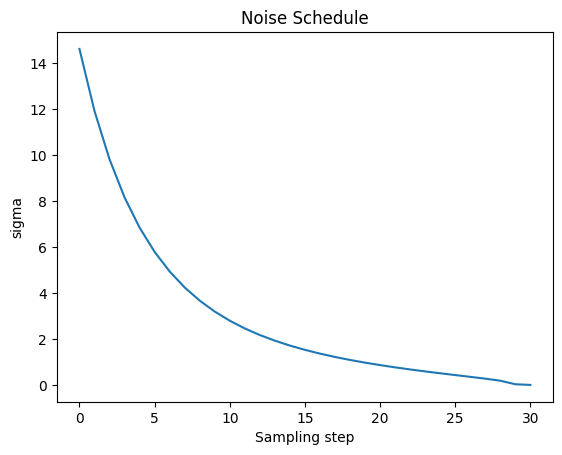

In [ ]:
# Set the number of sampling (inference) steps to 30 — much fewer than the 1000 steps used during training
set_timesteps(scheduler, 30)

# Print the actual timesteps being used during inference,
# mapped from the original training schedule of 1000 steps
print(f"Here are the actual imesteps being used during inference mapped from the original training schedule of 1000 steps:\n{scheduler.timesteps}")

# Print the noise levels (sigmas) associated with each of the 30 inference steps
print(f"\nHere are the noise levels (sigmas) associated with each of the 30 inference steps:\n{scheduler.sigmas}")

# Plot the noise levels over the sampling steps
plt.plot(scheduler.sigmas)
plt.title('Noise Schedule')
plt.xlabel('Sampling step')        # Step index from 0 to 30
plt.ylabel('sigma')                # The corresponding noise level (std deviation)
plt.show()

**What is happening here?**
- During training, the model learned to denoise over 1000 timesteps, with a specific noise schedule.
- But using 1000 steps for inference is slow, so we typically use fewer steps (e.g., 15 or 50) at inference time.

**What do the sigmas here indicate?**
- These are the standard deviations of noise (σ) at each inference step (expected noise at a global level).
- High sigma = more noise to remove (earlier steps in reverse process)
  - Or in the forward process, more noise to add
- Low sigma = almost clean, just fine-tuning the sample (later steps in reverse process)
  - Or in the forward process, less noise to add


Let's visualize what this looks like by adding a bit of noise to our encoded image and then directly using the VAE decoder on this noised version:

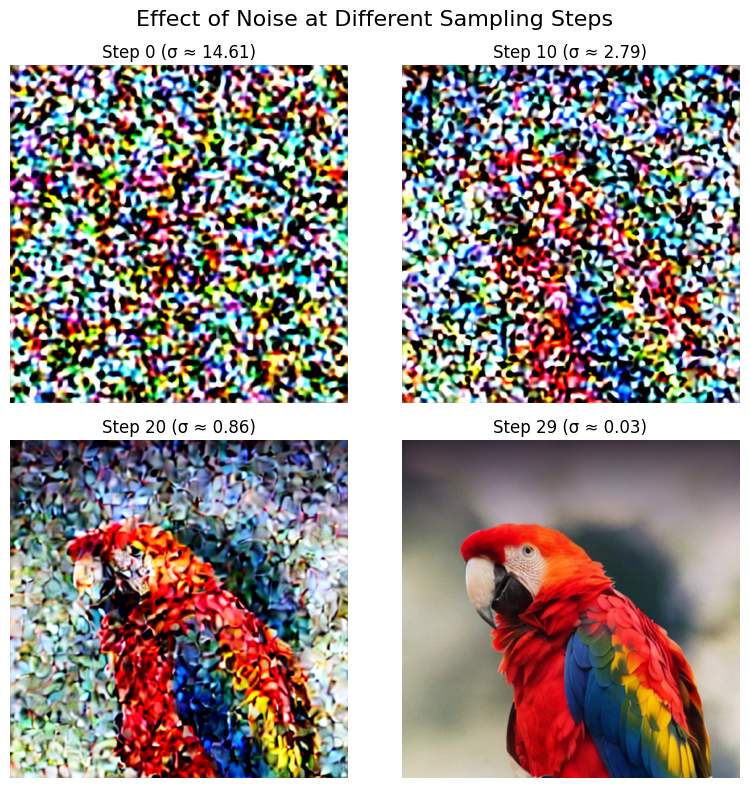

In [ ]:
import torch
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image

# Steps to visualize
sampling_steps = [0, 10, 20, 29]

# Prepare 2x2 plot
fig, axes = plt.subplots(2, 2, figsize=(8, 8))
axes = axes.flatten()

for i, step in enumerate(sampling_steps):
    # Generate random noise
    noise = torch.randn_like(encoded)

    # Get corresponding timestep
    timestep = torch.tensor([scheduler.timesteps[step]])

    # Add scaled noise using the scheduler
    noised_latent = scheduler.add_noise(encoded, noise, timestep)

    # Convert (using VAE decoder) to PIL and plot
    img = latents_to_pil(noised_latent.float())[0]

    axes[i].imshow(img)
    axes[i].set_title(f"Step {step} (σ ≈ {scheduler.sigmas[step]:.2f})")
    axes[i].axis('off')

plt.suptitle("Effect of Noise at Different Sampling Steps", fontsize=16)
plt.tight_layout()
plt.show()


## Component 4: Reverse Diffusion with U-Net

**What is the U-Net?**
- The U-Net is the core neural network used during the reverse diffusion process.
- It’s responsible for **predicting the noise component** that was added to the image at that timestep.
- From this prediction, we can estimate the clean image (your best guess at the underlying image for this step).
- But this would be a one-step approximation of the clean image so, to get a better image over time, we need to:
  - Use the scheduler to move towards less noisy latent
  - Repeat this T times based on the scheduler's timesteps.

In [ ]:
prompt = 'Oil painting of an otter in a top hat'
height = 512
width = 512
num_inference_steps = 50
guidance_scale = 8
generator = torch.manual_seed(32)
batch_size = 1

# Make a folder to store results
!rm -rf steps/
!mkdir -p steps/

# --------------------------------------------
# Text Embedding Preparation
# --------------------------------------------

# Tokenize and encode the prompt
text_input = tokenizer(
    [prompt],
    padding="max_length",
    max_length=tokenizer.model_max_length,
    truncation=True,
    return_tensors="pt"
)
with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]

# Prepare unconditional input for classifier-free guidance (empty string)
uncond_input = tokenizer(
    [""] * batch_size,
    padding="max_length",
    max_length=text_input.input_ids.shape[-1],
    return_tensors="pt"
)
with torch.no_grad():
    uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]

# Concatenate unconditional and conditional embeddings for guidance
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

# --------------------------------------------
# Latent (Random Noise Input) Initialization
# --------------------------------------------

# Set the scheduler timesteps
set_timesteps(scheduler, num_inference_steps)

# Sample initial noisy latents
latents = torch.randn(
    (batch_size, unet.in_channels, height // 8, width // 8),
    generator=generator
).to(torch_device)

# Scale initial noise by scheduler's sigma to prepare for the scheduler
latents = latents * scheduler.init_noise_sigma

# --------------------------------------------
# Denoising Loop
# --------------------------------------------

for i, t in tqdm(enumerate(scheduler.timesteps), total=len(scheduler.timesteps)):
    # Duplicate latents for classifier-free guidance
    latent_model_input = torch.cat([latents] * 2)

    # Scale input depending on timestep (so that the latent matches the U-Net's expected noise scale for timestep t)
    latent_model_input = scheduler.scale_model_input(latent_model_input, t)

    # UNet predicts the noise present in the latent image
    with torch.no_grad():
        noise_pred = unet(
            latent_model_input,
            t,
            encoder_hidden_states=text_embeddings
        )["sample"]

    # Separate predictions for conditional and unconditional branches
    noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)

    # Combine using guidance scale to steer toward text prompt
    noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

    # Use the scheduler to compute the next denoised latent state
    scheduler_step = scheduler.step(noise_pred, t, latents)
    latents = scheduler_step.prev_sample  # Move one step closer to the clean image

    # Convert current latent to image and save
    im = latents_to_pil(latents)[0]
    im.save(f'steps/{i:04}.jpeg')


/tmp/ipython-input-66-3526450735.py:50: FutureWarning: Accessing config attribute `in_channels` directly via 'UNet2DConditionModel' object attribute is deprecated. Please access 'in_channels' over 'UNet2DConditionModel's config object instead, e.g. 'unet.config.in_channels'.
  (batch_size, unet.in_channels, height // 8, width // 8),


  0%|          | 0/50 [00:00<?, ?it/s]

In [ ]:
# Make and show the progress video (change width to 1024 for full res)
!ffmpeg -v 1 -y -f image2 -framerate 12 -i steps/%04d.jpeg -c:v libx264 -preset slow -qp 18 -pix_fmt yuv420p out.mp4
mp4 = open('out.mp4','rb').read()
data_url = "data:video/mp4;base64," + b64encode(mp4).decode()
HTML("""
<video width=600 controls>
      <source src="%s" type="video/mp4">
</video>
""" % data_url)

## Time for Some Tricks!

Let's take a look at two tricks that we can play with now that we've understood the basic building components of the Diffusion model:

### Combining Embeddings!

We can see how combining two text prompts leads to a generated picture of both of those prompts at the same time!

  0%|          | 0/30 [00:00<?, ?it/s]

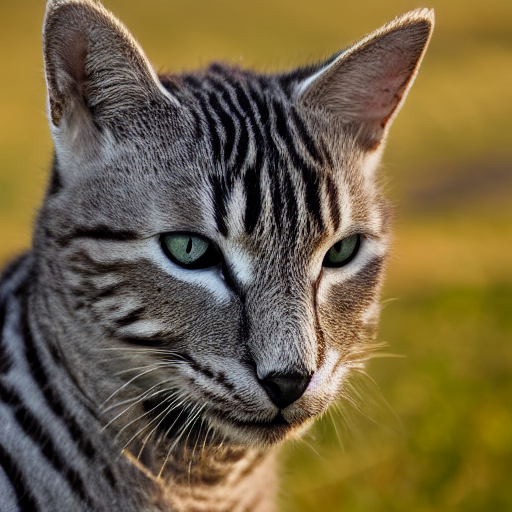

In [ ]:
# Embed two prompts
text_input1 = tokenizer(["A zebra"], padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
text_input2 = tokenizer(["A cat"], padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
with torch.no_grad():
    text_embeddings1 = text_encoder(text_input1.input_ids.to(torch_device))[0]
    text_embeddings2 = text_encoder(text_input2.input_ids.to(torch_device))[0]

# Mix them together
mix_factor = 0.55
mixed_embeddings = (text_embeddings1*mix_factor + \
                   text_embeddings2*(1-mix_factor))

# Generate!
generate_with_embs(mixed_embeddings)

### Img2Img

What if we want to create an image by combining a text prompt and an image that we begin with?

In [ ]:
# --------------------------------------------
# Settings (same as before except for the new prompt)
# --------------------------------------------

prompt = ["A colorful dancer, nat geo photo"]
height = 512                        # Default height of Stable Diffusion
width = 512                         # Default width of Stable Diffusion
num_inference_steps = 50            # Number of denoising steps
guidance_scale = 8                  # Scale for classifier-free guidance
generator = torch.manual_seed(32)   # Seed generator to create the initial latent noise
batch_size = 1                      # Number of images to generate

# --------------------------------------------
# Text Embedding Preparation
# --------------------------------------------

# Tokenize and encode the prompt
text_input = tokenizer(
    prompt,
    padding="max_length",
    max_length=tokenizer.model_max_length,
    truncation=True,
    return_tensors="pt"
)
with torch.no_grad():
    text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]

# Prepare unconditional input for classifier-free guidance (empty string)
max_length = text_input.input_ids.shape[-1]
uncond_input = tokenizer(
    [""] * batch_size,
    padding="max_length",
    max_length=max_length,
    return_tensors="pt"
)
with torch.no_grad():
    uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]

# Concatenate unconditional and conditional embeddings for guidance
text_embeddings = torch.cat([uncond_embeddings, text_embeddings])

# --------------------------------------------
# Scheduler and Latent Initialization
# --------------------------------------------

# Set the scheduler timesteps (total number of denoising steps)
set_timesteps(scheduler, num_inference_steps)

# Choose starting point in the diffusion process
start_step = 10
start_sigma = scheduler.sigmas[start_step]

# Add noise to the encoded latents to simulate partially denoised state
noise = torch.randn_like(encoded)
latents = scheduler.add_noise(encoded, noise, timesteps=torch.tensor([scheduler.timesteps[start_step]]))
latents = latents.to(torch_device).float()

# --------------------------------------------
# Denoising Loop (starting from start_step)
# --------------------------------------------

for i, t in tqdm(enumerate(scheduler.timesteps), total=len(scheduler.timesteps)):
    if i >= start_step:  # Only denoise starting from the specified step

        # Duplicate latents for classifier-free guidance
        latent_model_input = torch.cat([latents] * 2)

        # Scale input depending on timestep
        latent_model_input = scheduler.scale_model_input(latent_model_input, t)

        # UNet predicts the noise present in the latent image
        with torch.no_grad():
            noise_pred = unet(
                latent_model_input,
                t,
                encoder_hidden_states=text_embeddings
            )["sample"]

        # Separate predictions for conditional and unconditional branches
        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)

        # Combine using guidance scale to steer toward text prompt
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

        # Use the scheduler to compute the next denoised latent state
        latents = scheduler.step(noise_pred, t, latents).prev_sample

# --------------------------------------------
# Final Output
# --------------------------------------------

# Convert the final latent to image
latents_to_pil(latents)[0]

### <font color="red"><b>BONUS CHALLENGE!</b></font>

